## Folding First Principles [Part 1]

In [1]:
%pylab inline
import colorsys
import torch

def relu(x): return np.maximum(0, x)

def generate_grid_points(grid_size=20, extent=1.0):
    coords = np.linspace(-extent, extent, grid_size)
    x_grid, y_grid = np.meshgrid(coords, coords)
    x_flat, y_flat = x_grid.flatten(), y_grid.flatten()
    distances = np.sqrt(x_flat**2 + y_flat**2)
    angles = np.arctan2(y_flat, x_flat)
    hues = (angles + np.pi) / (2 * np.pi)
    saturations = np.clip(distances / (extent * np.sqrt(2)), 0, 1)
    rgb_colors = np.array([colorsys.hsv_to_rgb(h, s, 1) for h, s in zip(hues, saturations)])
    return np.column_stack([x_flat, y_flat, rgb_colors])

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


- For some basic configurations of 2 hidden units, then maybe 3 and 4 (I don't think 1 hidden unit makes sense?)
- What pairs in the input space are getting mapped to the same outputs? Do these pairs define a valid fold we can do on real paper?
- May want to switch to manim, we'll see. Let's start here though. 

In [2]:
w1=np.array([[1, 0],
             [-1, 0]])
b1=np.array([0,0])

In [3]:
pts=generate_grid_points(20, 1)

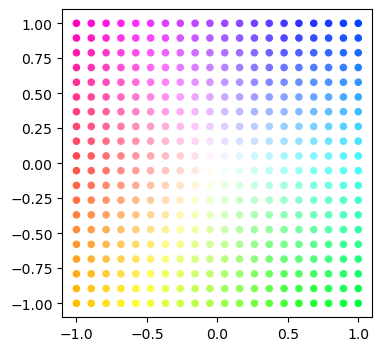

In [4]:
fig=plt.figure(0, (4,4))
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=20)

- Ok i think moving these points around is great for now.
- Visually would probably be nice to connect them into more of a grid. 

In [5]:
h11=relu(pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0])
h12=relu(pts[:,0]*w1[1,0]+pts[:,1]*w1[1,1]+b1[1])

j1=get_relu_joint(w1[0,0], w1[0,1], b1[0], 1.0)
j2=get_relu_joint(w1[1,0], w1[1,1], b1[1], 1.0)

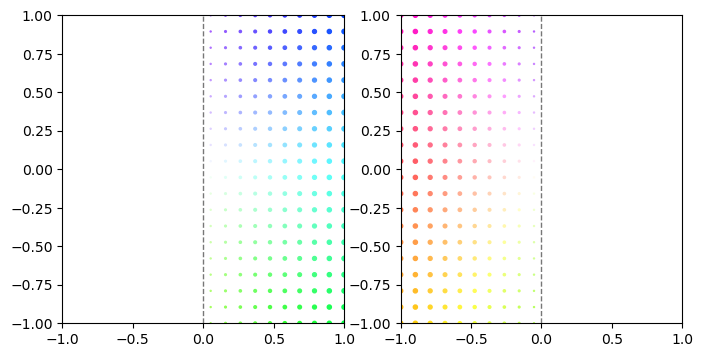

In [6]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h11)
plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

fig.add_subplot(1,2,2)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h12)
plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

- Ok cool cool - now what's a productive way to think about the core question here: 
- What pairs in the input space are getting mapped to the same outputs? Do these pairs define a valid fold we can do on real paper?
- Let me mess with the algebra for a moment...

$$
h_1=w_{1,1}x+w_{1,2}y+b_1
$$
$$
h_2=w_{2,1}x+w_{2,2}y+b_2
$$

Now what I'm I asking here mathematically...I'm trying to find sets of points like this: 

$$
(x_1, y_1) \rightarrow (h_1, h_2)
$$
$$
(x_2, y_2) \rightarrow (h_1, h_2)
$$

- Ok maybe starting more simply -> given an $(h_1, h_2)$ pair, what are all the (x, y) values that map to it? 
- I think there should be an analytical solution to this?
- Certainly for my starting weights right? Let's start there. 

$$
h_1=x
$$
$$
h_2=-x
$$

- Ok cool, so let's pick a real $(h_1, h_2)$ pair.
- How about (1,2)?
- Ok yeah so the solution is two lines, x=1, and x=-1, all these points map to the same $(h_1, h_2)$ pair of (1,2)
- And, they clearly define a valid fold on real paper.
- I think I'm starting to get a sense of how this works with more than 2 hidden neurons -> we can still figure out the geometry of points that get mapped to the same $(h_1, h_2, h_3)$ values. 

## Ok what about this pair of neurons?

In [7]:
w1=np.array([[1, 0],
             [0, 1]])
b1=np.array([0,0])

h11=relu(pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0])
h12=relu(pts[:,0]*w1[1,0]+pts[:,1]*w1[1,1]+b1[1])
j1=get_relu_joint(w1[0,0], w1[0,1], b1[0], 1.0)
j2=get_relu_joint(w1[1,0], w1[1,1], b1[1], 1.0)

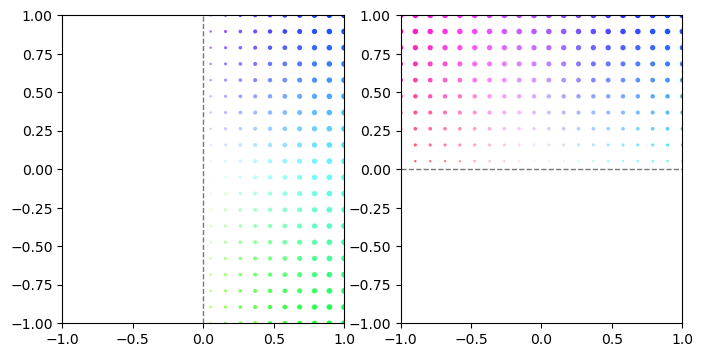

In [8]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h11)
plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

fig.add_subplot(1,2,2)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h12)
plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

*What pairs in the input space are getting mapped to the same outputs? Do these pairs define a valid fold we can do on real paper?*

$$
h_1=w_{1,1}x+w_{1,2}y+b_1
$$
$$
h_2=w_{2,1}x+w_{2,2}y+b_2
$$
$$
h_1=x
$$
$$
h_2=y
$$

- Maybe think about a point in each quadrant or something?
- Hmm that's kinda confusing, because the h space doesn't really have negatives, quadrants in the same way!
- Could consider (0,0), (0,1), (1,0), (1,1), (0.5, 0.5)
- h=(0,0) -> x=0, y=0
- h=(1,0) -> x=1, y=0
- h=(0,1) -> x=0, y=1
- Ok yeah this doesn't feel foldy at all! Is it because the dimensions are independent? No mixng means like no folds or something?
- Ok that doesn't fully make sense to me, but let me keep rolling/trying here.
- But yeah does not feel like folding behavior!

  
- Hmm hold on a second, returning to this for a moment.
- What about the ReLu? The above equations are actually not quite right. We do actually have a many to one thing for certain sets of points.
- h=(0,0) -> x=0, y=0 -OR, More Precisely -> x<=0, y<=0 
- h=(1,0) -> x=1, y=0 -OR -> x=1, y<=0
- h=(0,1) -> x=0, y=1 - -> x<=0, y=1
- h=(1,1) -> x=1, y=1 -> no many to one behaviors.
- Eh more like collaposing than folding right???

## Next Pair

In [9]:
w1=np.array([[1, 1],
             [0, 1]])
b1=np.array([0,0])

h11=relu(pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0])
h12=relu(pts[:,0]*w1[1,0]+pts[:,1]*w1[1,1]+b1[1])
j1=get_relu_joint(w1[0,0], w1[0,1], b1[0], 1.0)
j2=get_relu_joint(w1[1,0], w1[1,1], b1[1], 1.0)

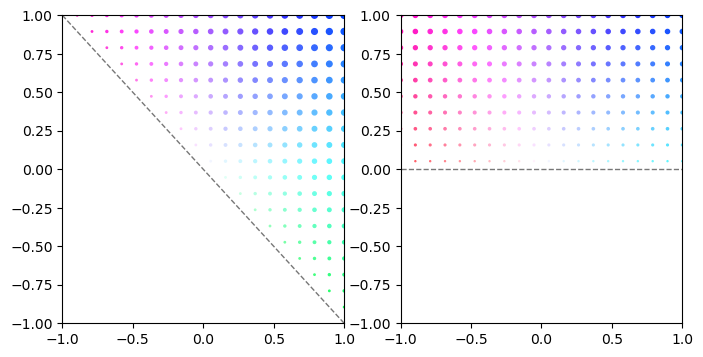

In [10]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h11)
plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

fig.add_subplot(1,2,2)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h12)
plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

*What pairs in the input space are getting mapped to the same outputs? Do these pairs define a valid fold we can do on real paper?*

$$
h_1=w_{1,1}x+w_{1,2}y+b_1
$$
$$
h_2=w_{2,1}x+w_{2,2}y+b_2
$$
$$
h_1=x+y
$$
$$
h_2=y
$$

- h=(0,0) -> x=0, y=0
- h=(1,0) -> x=1 -> vertical line?
- h=(0,1) -> y=1, x=-1
- h=(1,1) -> y=1, x=0
- h=(0.5, 0.5) -> y=0.5, x=0.5

Hmm ok still doesn't seem foldy, right? As far as I can tell the correspondances are 1:1....

## Next Example

In [11]:
w1=np.array([[1, 1],
             [1, 2]])
b1=np.array([0,0])

h11=relu(pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0])
h12=relu(pts[:,0]*w1[1,0]+pts[:,1]*w1[1,1]+b1[1])
j1=get_relu_joint(w1[0,0], w1[0,1], b1[0], 1.0)
j2=get_relu_joint(w1[1,0], w1[1,1], b1[1], 1.0)

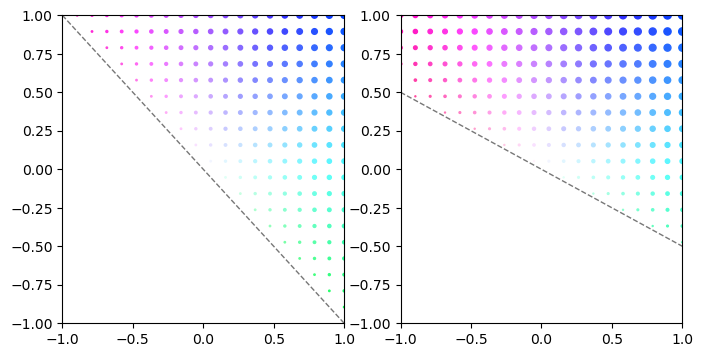

In [12]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h11)
plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

fig.add_subplot(1,2,2)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h12)
plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

*What pairs in the input space are getting mapped to the same outputs? Do these pairs define a valid fold we can do on real paper?*

$$
h_1=w_{1,1}x+w_{1,2}y+b_1
$$
$$
h_2=w_{2,1}x+w_{2,2}y+b_2
$$
$$
h_1=x+y
$$
$$
h_2=x+2y
$$

- h=(0,0) -> y=-x and y=-x/2
- h=(1,0) -> y=-x+1 and y=-x/2
- h=(0,1) -> y=-x and y=(-x+1)/2
- h=(1,1) -> y=-x+1 and y=(-x+1)/2
- h=(0.5, 0.5) -> y=-x+0.5, y=(-x+0.5)/2

- Ok kinda seems impossible that folding paper will make this happen, not sure yet though
- I'm also a little fuzzy on what exactly needs to happen on the paper -> do these two lines need to come together? Or something kinda different? The two lines coming together is what happened in th esumer simple case 1 right?

(-1.0, 1.0)

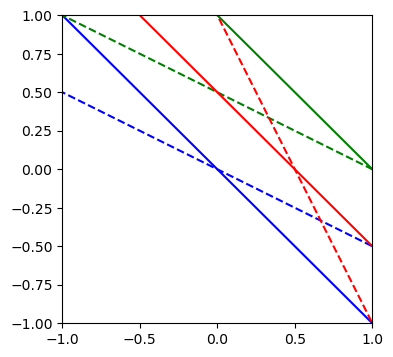

In [13]:
fig=figure(0,(4,4))
x=np.linspace(-5, 5, 10)
plot(x, -x, 'b')
plot(x, -x/2, 'b--')
plot(x, -x+1, 'g')
plot(x, (-x+1)/2, 'g--')
plot(x, -x+0.5, 'r')
plot(x, (-x+0.5)/0.5, 'r--')
plt.xlim([-1, 1]); plt.ylim([-1, 1])

- No what this is a valid fold right? 
- Hmm what am I missing here? If networks that are this simple cannot be implemented by physically folding paper, then is the analogy really worth that much???
- Is there some constraint on the network that would turn this back into a valid fold but not totaly nueter the network?
- Fold and cut theorem kinda suggests that there is right?
- If we could do a "stretchy fold" -> maybe fun manim animation -> would this work? Hard to picture in my head but maybe? Is there an affine transformation of the pictue above thar in a valid paper fold???
- Maybe it's contraining the wieghts so they can rotate but not stretch the input space?
- Maybe that's a good thing to try next!

## Valid Rotation Matrix
- If this works, will it still work if I add bias values? That would be important for not neutering the network!

$$
\begin{bmatrix}
\cos \theta & -\sin \theta \\  
\sin \theta & \cos \theta 
\end{bmatrix} 
$$

- Tempted to jump to like 30 or 45 degrees, but maybe we try 90 real quick first? 

In [14]:
w1=np.array([[0, -1],
             [1, 0]])
b1=np.array([0,0])

h11=relu(pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0])
h12=relu(pts[:,0]*w1[1,0]+pts[:,1]*w1[1,1]+b1[1])
j1=get_relu_joint(w1[0,0], w1[0,1], b1[0], 1.0)
j2=get_relu_joint(w1[1,0], w1[1,1], b1[1], 1.0)

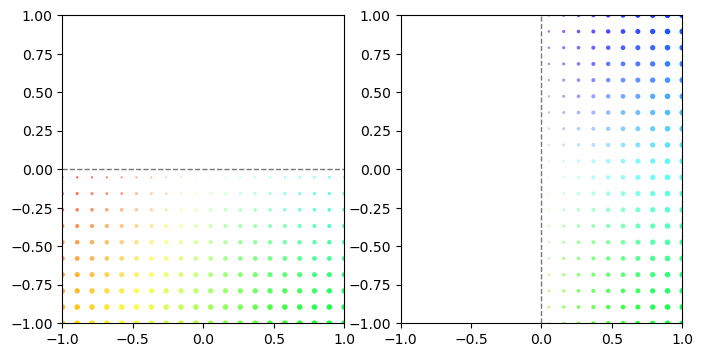

In [15]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h11)
plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

fig.add_subplot(1,2,2)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h12)
plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

- Ok yeah this will be the same problem as before I think? Like no mixing/folding? No 2:1 behavior?
- I can go though math, but this is going to be more collapsing than folding - 90% sure. 

## Next Rotation Matrix

In [16]:
np.cos(np.pi/6), sqrt(3)/2, np.sin(np.pi/6)

(0.8660254037844387, 0.8660254037844386, 0.49999999999999994)

In [17]:
w1=np.array([[sqrt(3)/2, -0.5],
             [0.5, sqrt(3)/2]])
b1=np.array([0,0])

h11=relu(pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0])
h12=relu(pts[:,0]*w1[1,0]+pts[:,1]*w1[1,1]+b1[1])
j1=get_relu_joint(w1[0,0], w1[0,1], b1[0], 1.0)
j2=get_relu_joint(w1[1,0], w1[1,1], b1[1], 1.0)

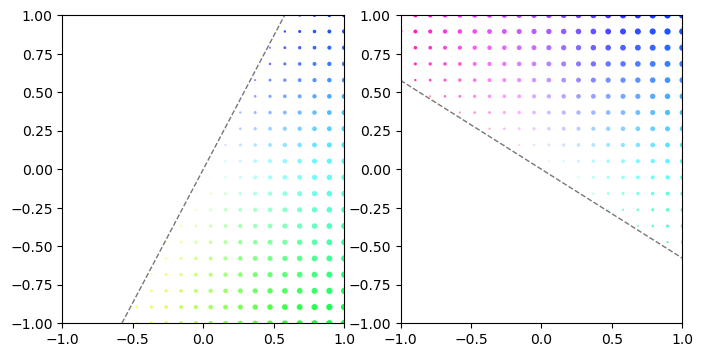

In [18]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h11)
plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

fig.add_subplot(1,2,2)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h12)
plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

*What pairs in the input space are getting mapped to the same outputs? Do these pairs define a valid fold we can do on real paper?*

$$
h_1=(\sqrt{3}/2)x-(1/2)y
$$
$$
h_2=(1/2)x+(\sqrt{3}/2)y
$$

- h=(0,0) -> $y=\sqrt{3}x$, $y=-(1/\sqrt{3})x$
- h=(1,0) -> $y=\sqrt{3}x-2$, $y=-(1/\sqrt{3})x$
- h=(0,1) -> 
- h=(1,1) ->
- h=(0.5, 0.5) ->

(-2.0, 2.0)

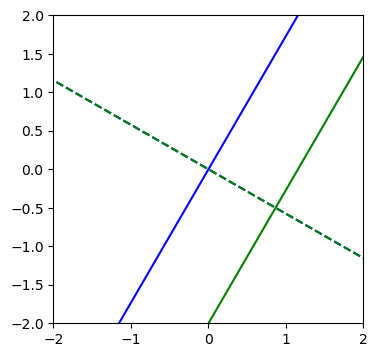

In [19]:
fig=figure(0,(4,4))
x=np.linspace(-5, 5, 10)
plot(x, np.sqrt(3)*x, 'b')
plot(x, (-1/np.sqrt(3))*x, 'b--')
plot(x, np.sqrt(3)*x-2, 'g')
plot(x, -(1/np.sqrt(3))*x, 'g--')
# plot(x, -x+0.5, 'r')
# plot(x, (-x+0.5)/0.5, 'r--')
plt.xlim([-2, 2]); plt.ylim([-2, 2])

- Ok i might have made a mistake here, but I don't feel like there a fold that brings teach dotted line on top of each corresponding solid line...
- Is it like each neuron does one fold somehow? Is that kinda what I'm missing???
- Hmmmm.
- I'm getting more precise, which is good! But my haven't cracked the nut yet!

## Equations from Reflection Formula

In [20]:
w1=np.array([[-3/5., -4/5],
             [-4/5, 3/5]])
b1=np.array([-4/5,-2/5])

h11=relu(pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0])
h12=relu(pts[:,0]*w1[1,0]+pts[:,1]*w1[1,1]+b1[1])
j1=get_relu_joint(w1[0,0], w1[0,1], b1[0], 1.0)
j2=get_relu_joint(w1[1,0], w1[1,1], b1[1], 1.0)

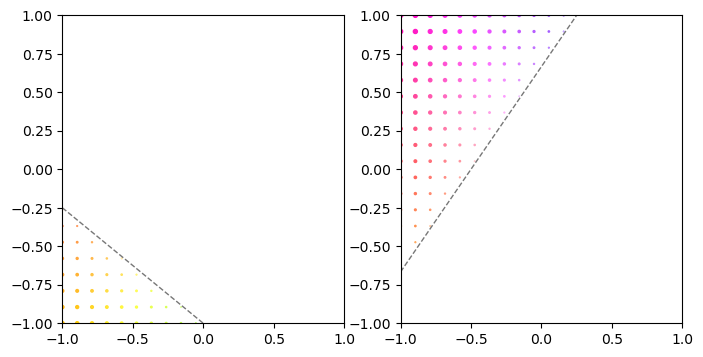

In [21]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h11)
plot([j1[0][0], j1[1][0]], [j1[0][1], j1[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

fig.add_subplot(1,2,2)
scatter(pts[:,0], pts[:,1], color=pts[:,2:], s=10*h12)
plot([j2[0][0], j2[1][0]], [j2[0][1], j2[1][1]], '--', color='#777777', linewidth=1)
plt.xlim([-1, 1]); plt.ylim([-1, 1]);

*What pairs in the input space are getting mapped to the same outputs? Do these pairs define a valid fold we can do on real paper?*

$$
h_1=-(3/5)x-(4/5)y-4/5
$$
$$
h_2=-(4/5)x+(3/5)y-2/5
$$


- h=(0,0) -> y = -(3/4)x - 1, y = (4/3)x + 2/3 #From Claude
- h=(1,0) -> y = -(3/4)x - 9/4, y = (4/3)x + 2/3
- h=(0,1) -> 
- h=(1,1) ->
- h=(0.5, 0.5) -> y = -(3/4)x - 13/8, y = (4/3)x + 3/2

(-2.0, 2.0)

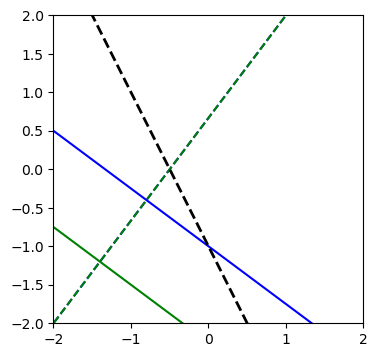

In [23]:
fig=figure(0,(4,4))
x=np.linspace(-5, 5, 10)
plot(x, -(3/4)*x - 1, 'b')
plot(x, (4/3)*x + 2/3, 'b--')
plot(x, -(3/4)*x - 9/4, 'g')
plot(x, (4/3)*x + 2/3, 'g--')

plot(x, -2*x-1, 'k--', linewidth=2)

# plot(x, -x+0.5, 'r')
# plot(x, (-x+0.5)/0.5, 'r--')
plt.xlim([-2, 2]); plt.ylim([-2, 2])

- Well this makes no sense lol. 
- Hmm is the ReLu messing stuff up actually? Yeah I'm not 100%, but I think that might be what's going on!

- h=(0,0) ->
- h=(1,0) -> 
- h=(0,1) -> 
- h=(1,1) ->
- h=(0.5, 0.5) ->

---

- Ok how do i figure out where the RelU joints are going to be?
- it's where `pts[:,0]*w1[0,0]+pts[:,1]*w1[0,1]+b1[0]=0`
- `x*w1[0,0]+y*w1[0,1]+b1[0]=0`
- `y=(-x*w1[0,0]-b1[0])/w1[0,1]`
- if `w1[0,1]=0`, then we're looking for when `x=-b1[0]/w1[0,0]`

In [ ]:
# def get_relu_joint(weight_1, weight_2, bias, extent=1):
#     '''Ok just need to tweak for cases where ReLu joint line bumps into x=-1,1 or y=-1,1'''
#     if np.abs(weight_2)<1e-8: 
#         return [[-bias/weight_1, -extent], [-bias/weight_1, extent]]
#     else: 
#         return (-x*w1[0,0]-b1[0])/w1[0,1]